# Wildfire Smoke Labor Productivity Analysis

This notebook analyzes the impact of wildfire smoke on labor productivity globally. It compares baseline PM2.5 concentrations with no-fire scenarios to estimate the productivity hours lost attributable to wildfire smoke.

## Data Requirements

This notebook requires the following data files in the `./smoke_data/` directory:
- PM2.5 concentration files:
  - `CESM_09x125_PM25_2050_RCP85.nc`: Baseline PM2.5 concentrations for 2050
  - `CESM_09x125_PM25_2050_RCP85_NoFire.nc`: No-fire PM2.5 concentrations for 2050
  - `CESM_09x125_PM25_2000_Baseline.nc`: Baseline PM2.5 concentrations for 2000
  - `CESM_09x125_PM25_2000_BaseLine_NoFire.nc`: No-fire PM2.5 concentrations for 2000
- `ssp2_2050_matching.nc`: Population projections
- Natural Earth shapefiles for country boundaries

The notebook will output CSV files with smoke-related productivity losses by country.

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import cartopy.io.shapereader as shpreader
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape
import pandas as pd
from shapely.geometry import Point, Polygon
from cartopy.io.shapereader import Reader
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

## Setup Data Directory

Check if the data directory exists and contains required files.

In [3]:
# Define the data directory relative to the notebook location
data_dir = './smoke_data'
output_dir = './smoke_data/results'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the RCP scenario - can be set to either "45" or "85"
rcp_scenario = "85"  # Default to RCP 8.5
rcp_display = f"RCP {rcp_scenario[0]}.{rcp_scenario[1]}"  # Format as "RCP 8.5" or "RCP 4.5"

# Check if data directory exists
if not os.path.exists(data_dir):
    print(f"Error: Data directory '{data_dir}' not found.")
    print("Please create a 'data' directory in the same location as this notebook and add the required data files.")
    required_files = [
        f'CESM_09x125_PM25_2050_RCP{rcp_scenario}.nc',
        f'CESM_09x125_PM25_2050_RCP{rcp_scenario}_NoFire.nc',
        'CESM_09x125_PM25_2000_Baseline.nc',
        'CESM_09x125_PM25_2000_BaseLine_NoFire.nc',
        'ssp2_2050_matching.nc'
    ]
    print(f"Required files: {', '.join(required_files)}")
    # Uncomment the line below if you want the notebook to stop execution when data is missing
    # sys.exit(1)

## Helper Functions

Define utility functions for data processing and visualization.

In [4]:
def fix_lon(ds):
    """Adjust longitude values to ensure they are within (-180, 180) range.
    
    Parameters:
        ds (xarray.Dataset): Dataset with longitude coordinates
        
    Returns:
        xarray.Dataset: Dataset with adjusted longitude coordinates
    """
    lon_name = 'lon'  # whatever name is in the data

    # Adjust lon values to make sure they are within (-180, 180)
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    ds = (
        ds
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
        .drop_vars(lon_name))

    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds

In [5]:
def nth_percentile(xarray_data, n):
    """Calculate the nth percentile of an xarray."""
    return xarray_data.quantile(n / 100, dim=None, method="linear").values.item()

In [6]:
def global_pcolormesh_country_borders(
    ds,
    title=None,
    cmap='viridis',  # Changed default from 'Reds' to 'viridis' for better color distinction
    cbar_label=None,
    cbar_ticks=None,
    cbar_ticklabels=None,
    cbar_orientation='vertical',
    vmin=None,
    vmax=None,
    bounds=None,
    colors=None,
    figsize=(12, 6),  # Increased default figure size for better visibility
    use_scientific=False,
    annotate_hotspots=False,  # Add option to annotate hotspots
    add_gridlines=True,  # Add option for gridlines
    data_attribution=None  # Add attribution text for data source
):
    """
    Create a global pcolormesh plot with country borders.
    
    Parameters:
        ds (xarray.Dataset): The dataset containing the variable to plot.
        title (str): Title of the plot.
        cmap (str): Colormap to use.
        cbar_label (str): Label for the colorbar.
        cbar_ticks (list): Ticks for the colorbar.
        cbar_ticklabels (list): Tick labels for the colorbar.
        cbar_orientation (str): Orientation of the colorbar ('vertical' or 'horizontal').
        vmin (float): Minimum value for colormap scaling.
        vmax (float): Maximum value for colormap scaling.
        bounds (list): Boundaries for discrete colormap.
        colors (list): Colors for discrete colormap.
        figsize (tuple): Size of the figure.
        use_scientific (bool): Whether to use scientific notation for colorbar.
        annotate_hotspots (bool): Whether to annotate high-value regions.
        add_gridlines (bool): Whether to add gridlines to the map.
        data_attribution (str): Attribution text for data source.
    
    Returns:
        matplotlib.figure.Figure: The figure object
    """
    temp_ds = ds.copy()
    
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})

    if bounds is not None:
        norm = mcolors.BoundaryNorm(bounds, len(colors))
        cmap = mcolors.ListedColormap(colors)
        p = temp_ds.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            add_colorbar=False
        )
    else:
        # Plotting the data
        p = temp_ds.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        
    # Adding map features
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.1)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    
    # Add gridlines if requested
    if add_gridlines:
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
    
    # Adding title with larger font
    if title:
        plt.title(title, fontsize=14, fontweight='bold')
    
    # Adding colorbar
    if cbar_label:
        cbar = plt.colorbar(p, ax=ax, orientation=cbar_orientation, pad=0.02)
        cbar.set_label(cbar_label, fontweight='bold')
        
        if cbar_ticks is not None:
            cbar.set_ticks(cbar_ticks)
        
        if cbar_ticklabels is not None:
            cbar.ax.set_yticklabels(cbar_ticklabels)
            
        # Format colorbar tick labels to avoid scientific notation
        if not use_scientific:
            formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
            cbar.formatter = formatter
            cbar.update_ticks()
    
    # Add a small attribution text at the bottom right
    if data_attribution:
        plt.annotate(data_attribution, xy=(0.99, 0.01), xycoords='axes fraction', 
                    fontsize=8, ha='right', va='bottom', alpha=0.7)
    
    plt.tight_layout()
    return fig

In [7]:
# Function to get the sum of values within each country and return as a pandas Series
def sum_within_country(data, countries):
    """Calculate the sum of values within each country's boundaries.
    
    Parameters:
        data (xarray.DataArray): Grid data to sum within country boundaries
        countries (list): List of country geometries
        
    Returns:
        pandas.Series: Series with country names as index and summed values
    """
    temp_data = data.copy()
    country_sums = []
    country_names = []
    
    # Get country info from shapefile
    shapefile = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shapefile)
    country_info = list(reader.records())
    
    # Assuming data is an xarray.DataArray with 'lat' and 'lon' as coordinates
    lats = temp_data.coords['lat'].values
    lons = temp_data.coords['lon'].values
    
    for country, country_attr in zip(countries, country_info):
        clist = []
        country_name = country_attr.attributes['NAME']  # Get country name from the attributes
        country_polygon = shape(country)  # Convert country geometry to a shapely polygon
        
        # Create a meshgrid for latitude and longitude values
        lat_idx, lon_idx = np.meshgrid(lats, lons, indexing="ij")
        
        # Create an array of points
        points = np.array([Point(lon, lat) for lat, lon in zip(lat_idx.ravel(), lon_idx.ravel())])
        
        # Check which points are within the country's polygon
        inside_country = np.array([country_polygon.contains(point) for point in points])
        
        # Get the data values corresponding to the points inside the country
        inside_values = data.values.ravel()[inside_country]
        
        # Sum the values within the country
        country_sum = np.nansum(inside_values)
        
        # Append the country name and its corresponding sum to the lists
        country_sums.append(country_sum)
        country_names.append(country_name)
    
    # Return a pandas Series with the country name as the index and sum as the values
    return pd.Series(country_sums, index=country_names, name='Productivity Loss (Hours)')

In [8]:
def productivity_loss_hours(pm25, population):
    """Calculate productivity loss hours based on PM2.5 concentration and population.
    
    Parameters:
        pm25 (xarray.DataArray): PM2.5 concentration
        population (xarray.DataArray): Population count
        
    Returns:
        xarray.DataArray: Calculated productivity loss hours
    """
    # Constants
    annual_work_hours = 2000  # Average annual work hours per person
    productivity_loss_rate = 0.001  # 0.1% productivity loss per unit of PM2.5
    labor_force_participation = 0.58  # Global labor force participation rate (58%)
    
    # Calculate labor force from population
    labor_force = population * labor_force_participation
    
    # Calculate productivity loss hours: LaborForce × WorkHours × 0.001 × PM2.5
    loss_hours = labor_force * annual_work_hours * productivity_loss_rate * pm25
    
    # Ensure coordinates are consistent
    loss_hours['lon'] = loss_hours['lon']
    
    return loss_hours

## Load Data

Load PM2.5 concentration data and population projections.

In [9]:
# Load PM2.5 data for 2050 RCP scenario
try:
    baseline_pm25_2050 = xr.open_dataset(os.path.join(data_dir, f'CESM_09x125_PM25_2050_RCP{rcp_scenario}.nc'))['pm25'].mean(axis=0)
    nofire_pm25_2050 = xr.open_dataset(os.path.join(data_dir, f'CESM_09x125_PM25_2050_RCP{rcp_scenario}_NoFire.nc'))['pm25'].mean(axis=0)
    baseline_pm25_2050 = fix_lon(baseline_pm25_2050)
    nofire_pm25_2050 = fix_lon(nofire_pm25_2050)
    print(f"Successfully loaded PM2.5 data for 2050 {rcp_display} scenario")
except Exception as e:
    print(f"Error loading PM2.5 data for 2050: {e}")

Successfully loaded PM2.5 data for 2050 RCP 8.5 scenario


In [10]:
# Load PM2.5 data for 2000 baseline scenario
try:
    baseline_pm25_2000 = xr.open_dataset(os.path.join(data_dir, 'CESM_09x125_PM25_2000_Baseline.nc'))['pm25'].mean(axis=0)
    nofire_pm25_2000 = xr.open_dataset(os.path.join(data_dir, 'CESM_09x125_PM25_2000_BaseLine_NoFire.nc'))['pm25'].mean(axis=0)
    baseline_pm25_2000 = fix_lon(baseline_pm25_2000)
    nofire_pm25_2000 = fix_lon(nofire_pm25_2000)
    print("Successfully loaded PM2.5 data for 2000 baseline scenario")
except Exception as e:
    print(f"Error loading PM2.5 data for 2000: {e}")

Successfully loaded PM2.5 data for 2000 baseline scenario


Successfully loaded population data


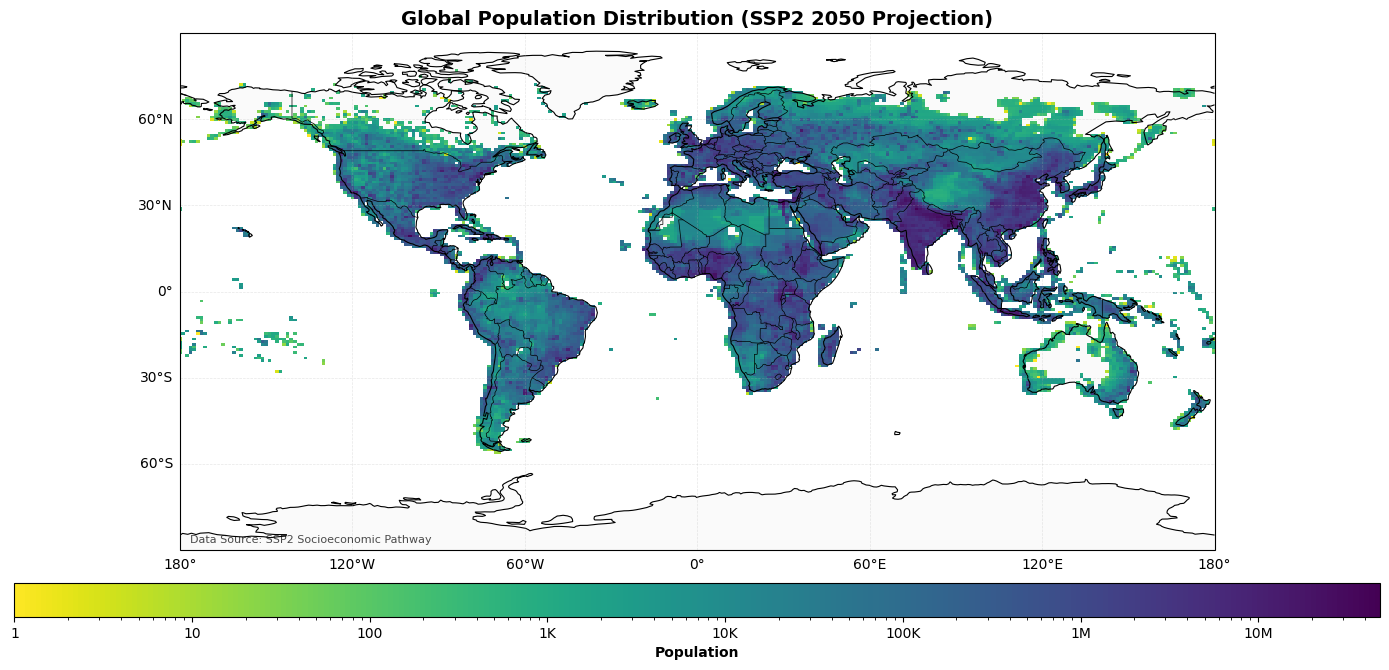

Total global population (SSP2 2050 projection): 9.190 billion (9,190,156,060.0 people)

Population by major world regions:
  Asia: 4.421 billion (48.1% of global population)
  Africa: 2.226 billion (24.2% of global population)
  Europe: 857.25 million (9.3% of global population)
  North America: 653.59 million (7.1% of global population)
  South America: 479.70 million (5.2% of global population)


In [11]:
# Load population data
try:
    population = xr.open_dataset(os.path.join(data_dir, 'ssp2_2050_matching.nc'))['ssp2_2050']
    population = fix_lon(population)
    
    # Align coordinates with PM2.5 data
    population['lat'] = baseline_pm25_2050['lat']
    population['lon'] = baseline_pm25_2050['lon']
    
    print("Successfully loaded population data")
    
    # Visualize the population data
    plt.figure(figsize=(14, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Use a custom colormap for population density
    pop_cmap = plt.cm.viridis_r
    
    # Use log scale for better visualization of population density
    norm = mcolors.LogNorm(vmin=1, vmax=population.max().values)
    
    # Plot the population data
    p = population.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=pop_cmap,
        norm=norm,
        add_colorbar=False
    )
    
    # Add map features
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.1)
    
    # Add a grid for better geographic reference
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Add a title
    plt.title('Global Population Distribution (SSP2 2050 Projection)', fontsize=14, fontweight='bold')
    
    # Add a custom-formatted colorbar
    cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Population', fontweight='bold')
    
    # Create a custom formatter for large numbers
    def pop_formatter(x, pos):
        if x >= 1e6:
            return f'{x/1e6:.0f}M'
        elif x >= 1e3:
            return f'{x/1e3:.0f}K'
        else:
            return f'{x:.0f}'
    
    cbar.ax.xaxis.set_major_formatter(plt.FuncFormatter(pop_formatter))
    
    # Add attribution
    plt.annotate('Data Source: SSP2 Socioeconomic Pathway', xy=(0.01, 0.01), xycoords='axes fraction', 
                fontsize=8, ha='left', va='bottom', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display total population
    total_population = population.sum().values.item()
    
    # Format the output to make it more readable
    if total_population >= 1e9:
        formatted_pop = f"{total_population/1e9:.3f} billion"
    else:
        formatted_pop = f"{total_population/1e6:.2f} million"
    
    print(f"Total global population (SSP2 2050 projection): {formatted_pop} ({total_population:,} people)")
    
    # Calculate populations by continental regions (rough approximation)
    # Define rough latitude/longitude bounds for regions
    regions = {
        "Asia": {"lat_min": 0, "lat_max": 55, "lon_min": 60, "lon_max": 150},
        "Africa": {"lat_min": -35, "lat_max": 35, "lon_min": -20, "lon_max": 55},
        "Europe": {"lat_min": 35, "lat_max": 70, "lon_min": -10, "lon_max": 40},
        "North America": {"lat_min": 15, "lat_max": 70, "lon_min": -170, "lon_max": -50},
        "South America": {"lat_min": -55, "lat_max": 15, "lon_min": -80, "lon_max": -35}
    }
    
    print("\nPopulation by major world regions:")
    for region, bounds in regions.items():
        region_pop = population.sel(
            lat=slice(bounds["lat_min"], bounds["lat_max"]),
            lon=slice(bounds["lon_min"], bounds["lon_max"])
        ).sum().values.item()
        
        if region_pop >= 1e9:
            formatted_region_pop = f"{region_pop/1e9:.3f} billion"
        else:
            formatted_region_pop = f"{region_pop/1e6:.2f} million"
            
        print(f"  {region}: {formatted_region_pop} ({region_pop/total_population*100:.1f}% of global population)")
    
except Exception as e:
    print(f"Error loading population data: {e}")

## Calculate Productivity Losses

Calculate productivity losses based on PM2.5 concentrations and population for both 2050 and 2000.

In [12]:
# Calculate productivity losses for 2050 scenarios
baseline_productivity_loss_2050 = productivity_loss_hours(baseline_pm25_2050, population)
nofire_productivity_loss_2050 = productivity_loss_hours(nofire_pm25_2050, population)

# Calculate the difference to isolate wildfire impact in 2050
wildfire_productivity_loss_2050 = baseline_productivity_loss_2050 - nofire_productivity_loss_2050

print("Calculated productivity losses for 2050 baseline and no-fire scenarios")

Calculated productivity losses for 2050 baseline and no-fire scenarios


In [13]:
# Calculate productivity losses for 2000 scenarios (using 2050 population for consistent comparison)
baseline_productivity_loss_2000 = productivity_loss_hours(baseline_pm25_2000, population)
nofire_productivity_loss_2000 = productivity_loss_hours(nofire_pm25_2000, population)

# Calculate the difference to isolate wildfire impact in 2000
wildfire_productivity_loss_2000 = baseline_productivity_loss_2000 - nofire_productivity_loss_2000

print("Calculated productivity losses for 2000 baseline and no-fire scenarios")

Calculated productivity losses for 2000 baseline and no-fire scenarios


In [14]:
# Calculate the change in productivity losses from 2000 to 2050
change_wildfire_productivity_loss = wildfire_productivity_loss_2050 - wildfire_productivity_loss_2000

print("Calculated change in wildfire-related productivity losses from 2000 to 2050")

Calculated change in wildfire-related productivity losses from 2000 to 2050


## Aggregate by Country

Sum productivity loss values within each country's boundaries.

In [15]:
# Load countries shapefile
try:
    shapefile = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shapefile)
    countries = list(reader.geometries())
    country_info = list(reader.records())
    print(f"Successfully loaded country boundaries from Natural Earth")
except Exception as e:
    print(f"Error loading country boundaries: {e}")

Successfully loaded country boundaries from Natural Earth


In [16]:
# Calculate country-level productivity losses for 2050
baseline_country_losses_2050 = sum_within_country(baseline_productivity_loss_2050, countries)
nofire_country_losses_2050 = sum_within_country(nofire_productivity_loss_2050, countries)
wildfire_country_losses_2050 = sum_within_country(wildfire_productivity_loss_2050, countries)

# Calculate country-level productivity losses for 2000
baseline_country_losses_2000 = sum_within_country(baseline_productivity_loss_2000, countries)
nofire_country_losses_2000 = sum_within_country(nofire_productivity_loss_2000, countries)
wildfire_country_losses_2000 = sum_within_country(wildfire_productivity_loss_2000, countries)

# Calculate change in country-level productivity losses from 2000 to 2050
wildfire_country_change = wildfire_country_losses_2050 - wildfire_country_losses_2000

print("Calculated country-level productivity losses")

Calculated country-level productivity losses


In [17]:
# Sum population by country to calculate per capita impacts
country_population = sum_within_country(population, countries)
country_population.name = 'Population'

# Calculate per capita productivity loss (hours/person) for 2050
per_capita_loss_2050 = wildfire_country_losses_2050 / country_population
per_capita_loss_2050.name = 'Per Capita Productivity Loss 2050 (Hours)'

# Calculate per capita productivity loss (hours/person) for 2000
per_capita_loss_2000 = wildfire_country_losses_2000 / country_population
per_capita_loss_2000.name = 'Per Capita Productivity Loss 2000 (Hours)'

# Calculate change in per capita productivity loss from 2000 to 2050
per_capita_change = per_capita_loss_2050 - per_capita_loss_2000
per_capita_change.name = 'Per Capita Productivity Loss Change 2000-2050 (Hours)'

print("Calculated per capita productivity losses")

Calculated per capita productivity losses


In [18]:
# Save results to CSV
os.makedirs(output_dir, exist_ok=True)

# 2050 results
baseline_country_losses_2050.to_csv(os.path.join(output_dir, f'total_productivity_loss_2050_{rcp_scenario}.csv'))
nofire_country_losses_2050.to_csv(os.path.join(output_dir, f'nofire_productivity_loss_2050_{rcp_scenario}.csv'))
wildfire_country_losses_2050.to_csv(os.path.join(output_dir, f'wildfire_productivity_loss_2050_{rcp_scenario}.csv'))

# 2000 results
baseline_country_losses_2000.to_csv(os.path.join(output_dir, 'total_productivity_loss_2000.csv'))
nofire_country_losses_2000.to_csv(os.path.join(output_dir, 'nofire_productivity_loss_2000.csv'))
wildfire_country_losses_2000.to_csv(os.path.join(output_dir, 'wildfire_productivity_loss_2000.csv'))

# Change from 2000 to 2050
wildfire_country_change.to_csv(os.path.join(output_dir, f'wildfire_productivity_loss_change_2000_2050_{rcp_scenario}.csv'))

# Per capita results
per_capita_loss_2050.to_csv(os.path.join(output_dir, f'wildfire_per_capita_productivity_loss_2050_{rcp_scenario}.csv'))
per_capita_loss_2000.to_csv(os.path.join(output_dir, 'wildfire_per_capita_productivity_loss_2000.csv'))
per_capita_change.to_csv(os.path.join(output_dir, f'wildfire_per_capita_productivity_loss_change_2000_2050_{rcp_scenario}.csv'))

print(f"Saved country-level productivity loss results to CSV files with {rcp_display} scenario identifier")

Saved country-level productivity loss results to CSV files with RCP 8.5 scenario identifier


## Summary Statistics

Display summary statistics for global productivity losses.

In [19]:
# Convert hours to work-years (assuming 2000 hours per work-year)
work_years_factor = 1/2000

print(f"2050 {rcp_display} RESULTS:")
print(f"Total productivity loss in 2050 baseline scenario: {baseline_country_losses_2050.sum():,.0f} hours")
print(f"Total productivity loss in 2050 baseline scenario: {baseline_country_losses_2050.sum() * work_years_factor:,.0f} work-years")
print(f"Total productivity loss in 2050 no-fire scenario: {nofire_country_losses_2050.sum():,.0f} hours")
print(f"Total productivity loss attributable to wildfire in 2050: {wildfire_country_losses_2050.sum():,.0f} hours")
print(f"Total productivity loss attributable to wildfire in 2050: {wildfire_country_losses_2050.sum() * work_years_factor:,.0f} work-years")

print(f"\n2000 RESULTS:")
print(f"Total productivity loss attributable to wildfire in 2000: {wildfire_country_losses_2000.sum():,.0f} hours")
print(f"Total productivity loss attributable to wildfire in 2000: {wildfire_country_losses_2000.sum() * work_years_factor:,.0f} work-years")

print(f"\nCHANGE FROM 2000 TO 2050 ({rcp_display}):")
print(f"Change in productivity loss attributable to wildfire: {wildfire_country_change.sum():,.0f} hours")
print(f"Change in productivity loss attributable to wildfire: {wildfire_country_change.sum() * work_years_factor:,.0f} work-years")
if wildfire_country_change.sum() > 0:
    print(f"Percent increase: {(wildfire_country_change.sum() / wildfire_country_losses_2000.sum() * 100):,.1f}%")
else:
    print(f"Percent decrease: {(-wildfire_country_change.sum() / wildfire_country_losses_2000.sum() * 100):,.1f}%")

2050 RCP 8.5 RESULTS:
Total productivity loss in 2050 baseline scenario: 215,000,767,150 hours
Total productivity loss in 2050 baseline scenario: 107,500,384 work-years
Total productivity loss in 2050 no-fire scenario: 188,530,361,098 hours
Total productivity loss attributable to wildfire in 2050: 26,470,406,051 hours
Total productivity loss attributable to wildfire in 2050: 13,235,203 work-years

2000 RESULTS:
Total productivity loss attributable to wildfire in 2000: 17,077,705,157 hours
Total productivity loss attributable to wildfire in 2000: 8,538,853 work-years

CHANGE FROM 2000 TO 2050 (RCP 8.5):
Change in productivity loss attributable to wildfire: 9,392,700,895 hours
Change in productivity loss attributable to wildfire: 4,696,350 work-years
Percent increase: 55.0%


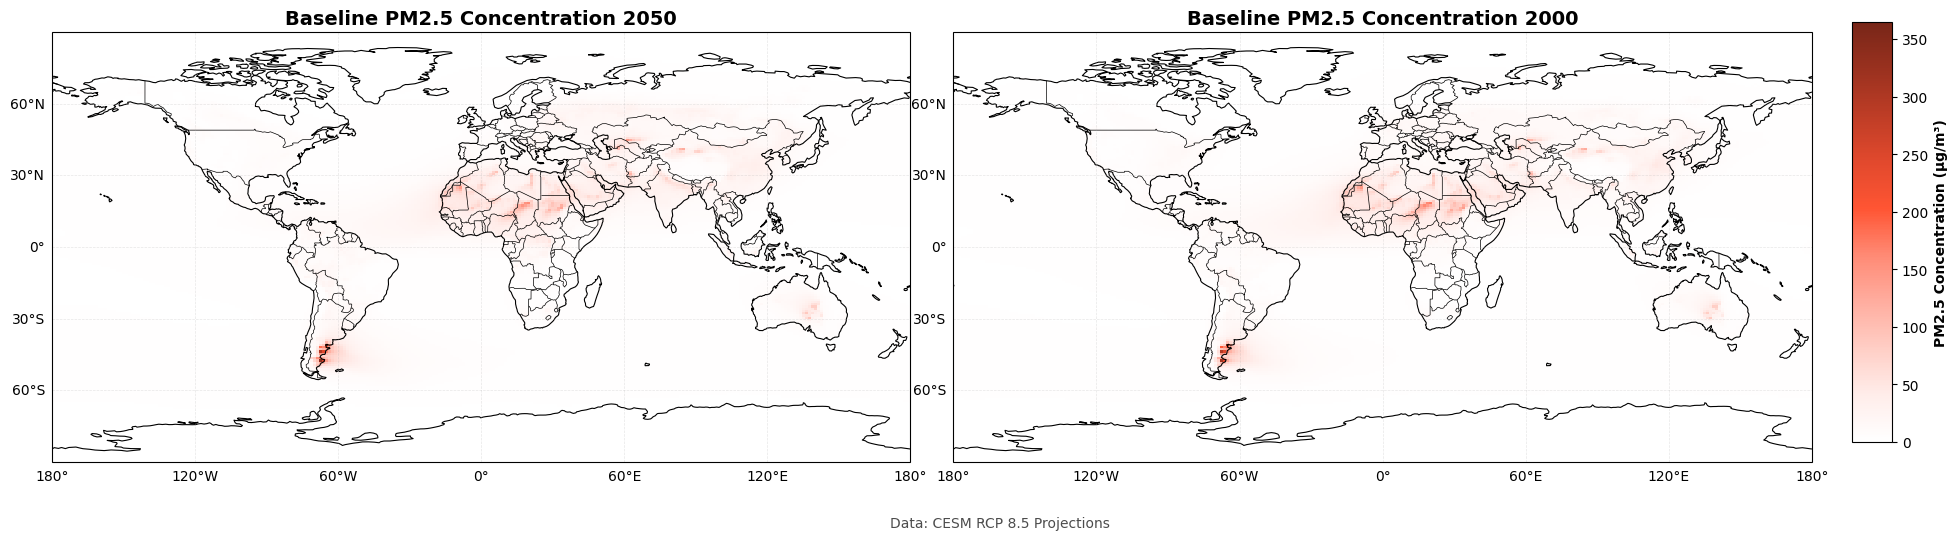

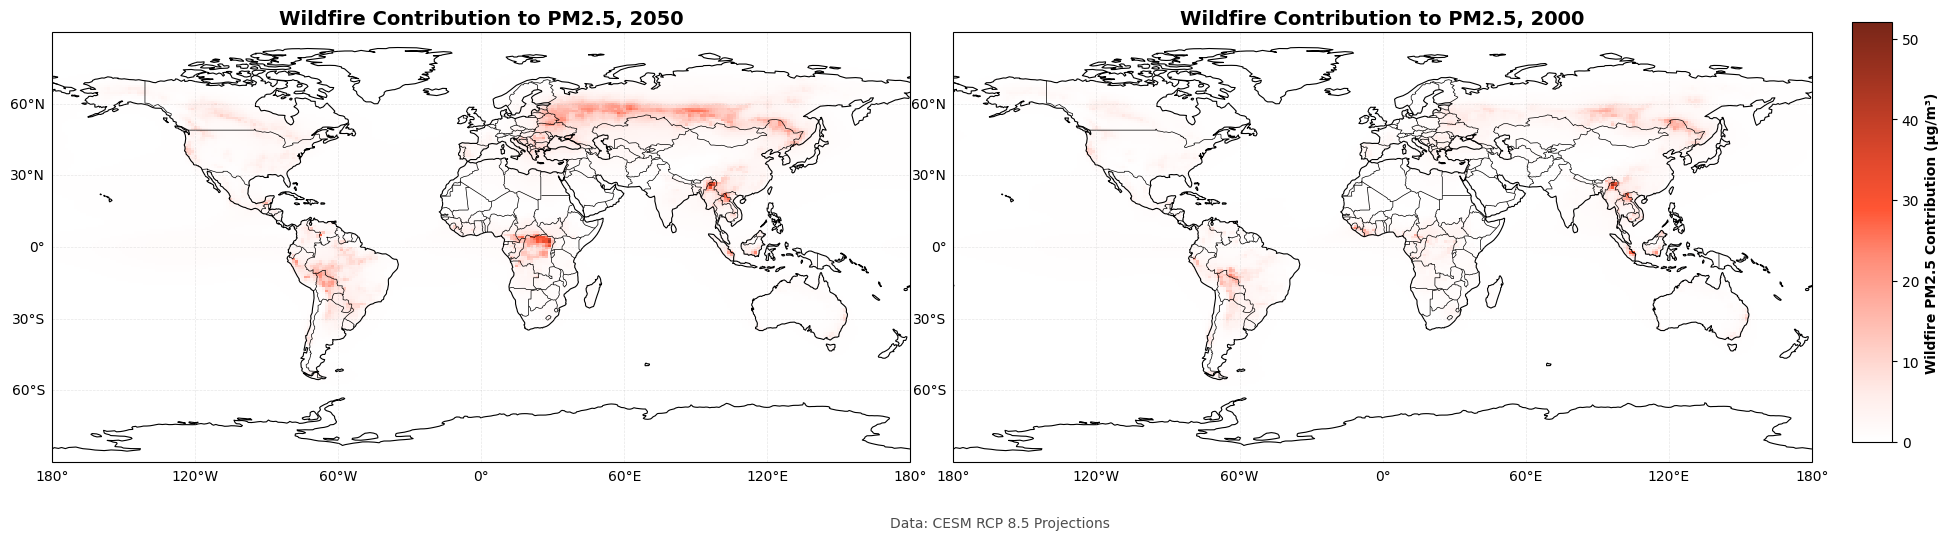

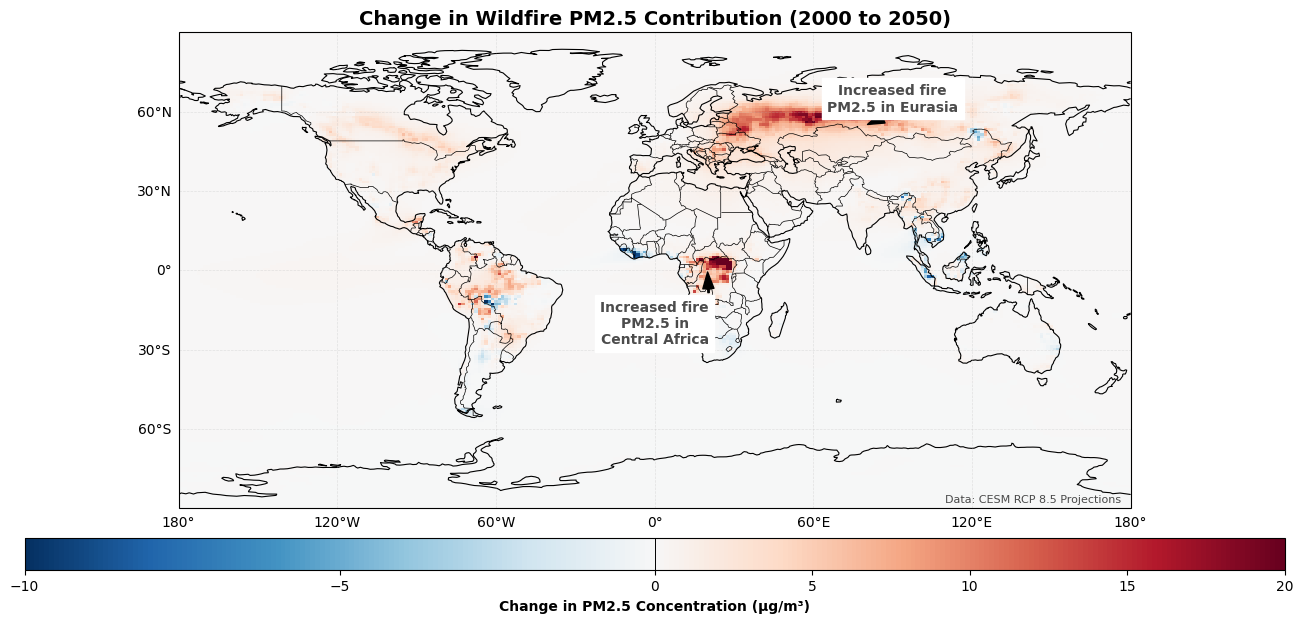

In [20]:
# Visualize baseline PM2.5 in 2050 and 2000
fig, axes = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Create a better white to red colormap for consistent use
pm25_colors = ['#ffffff', '#ffedea', '#ffcec5', '#ffad9f', '#ff8a75', '#ff5533', '#e2492d', '#be3d26', '#9a311f', '#782618']
pm25_cmap = mcolors.LinearSegmentedColormap.from_list('pm25_concentration', pm25_colors)

# 2050 baseline
p1 = baseline_pm25_2050.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap=pm25_cmap,  # Using consistent white to red colormap
    vmin=0,
    vmax=max(baseline_pm25_2050.max(), baseline_pm25_2000.max()),
    add_colorbar=False
)

# 2000 baseline
p2 = baseline_pm25_2000.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap=pm25_cmap,  # Using consistent white to red colormap
    vmin=0,
    vmax=max(baseline_pm25_2050.max(), baseline_pm25_2000.max()),
    add_colorbar=False
)

# Add features to both maps
for ax, year in zip(axes, ["2050", "2000"]):
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.1)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Add title
    ax.set_title(f"Baseline PM2.5 Concentration {year}", fontsize=14, fontweight='bold')

# Add common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(p1, cax=cbar_ax, orientation='vertical')
cbar.set_label('PM2.5 Concentration (μg/m³)', fontweight='bold')

# Add attribution
plt.annotate(f'Data: CESM {rcp_display} Projections', xy=(0.5, 0.01), xycoords='figure fraction', 
             fontsize=10, ha='center', va='bottom', alpha=0.7)

# Use explicit subplot adjustment instead of tight_layout
plt.subplots_adjust(left=0.02, right=0.9, top=0.9, bottom=0.05, wspace=0.05)
plt.show()

# Visualize fire contribution to PM2.5 in 2050 and 2000
fig, axes = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Calculate wildfire PM2.5 contribution
fire_pm25_2050 = baseline_pm25_2050 - nofire_pm25_2050
fire_pm25_2000 = baseline_pm25_2000 - nofire_pm25_2000

# Set consistent color scale
vmax = max(fire_pm25_2050.max(), fire_pm25_2000.max())

# 2050 fire contribution
p1 = fire_pm25_2050.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap=pm25_cmap,  # Using consistent white to red colormap
    vmin=0,
    vmax=vmax,
    add_colorbar=False
)

# 2000 fire contribution
p2 = fire_pm25_2000.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap=pm25_cmap,  # Using consistent white to red colormap
    vmin=0,
    vmax=vmax,
    add_colorbar=False
)

# Add features to both maps
for ax, year in zip(axes, ["2050", "2000"]):
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.1)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Add title
    ax.set_title(f"Wildfire Contribution to PM2.5, {year}", fontsize=14, fontweight='bold')

# Add common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(p1, cax=cbar_ax, orientation='vertical')
cbar.set_label('Wildfire PM2.5 Contribution (μg/m³)', fontweight='bold')

# Add attribution
plt.annotate(f'Data: CESM {rcp_display} Projections', xy=(0.5, 0.01), xycoords='figure fraction', 
             fontsize=10, ha='center', va='bottom', alpha=0.7)

# Use explicit subplot adjustment instead of tight_layout
plt.subplots_adjust(left=0.02, right=0.9, top=0.9, bottom=0.05, wspace=0.05)
plt.show()

# Visualize change in wildfire PM2.5 from 2000 to 2050
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Calculate the change
pm25_change = fire_pm25_2050 - fire_pm25_2000

# Use a diverging colormap for change
divnorm = mcolors.TwoSlopeNorm(vmin=-10, vcenter=0, vmax=20)
p = pm25_change.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',  # Red-Blue reversed for increased/decreased PM2.5
    norm=divnorm,
    add_colorbar=False
)

# Add features
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.1)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title
ax.set_title('Change in Wildfire PM2.5 Contribution (2000 to 2050)', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('Change in PM2.5 Concentration (μg/m³)', fontweight='bold')

# Add zero line to colorbar
cbar.ax.axvline(x=0, color='black', linestyle='-', linewidth=0.7)

# Add annotations for regions with significant changes
ax.annotate('Increased fire\nPM2.5 in Eurasia', xy=(80, 55), xytext=(90, 65),
           arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
           fontweight='bold', ha='center', va='center', backgroundcolor='white', alpha=0.7)

ax.annotate('Increased fire\nPM2.5 in\nCentral Africa', xy=(20, 0), xytext=(0, -20),
           arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
           fontweight='bold', ha='center', va='center', backgroundcolor='white', alpha=0.7)

# Add attribution
plt.annotate(f'Data: CESM {rcp_display} Projections', xy=(0.99, 0.01), xycoords='axes fraction', 
             fontsize=8, ha='right', va='bottom', alpha=0.7)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
plt.show()

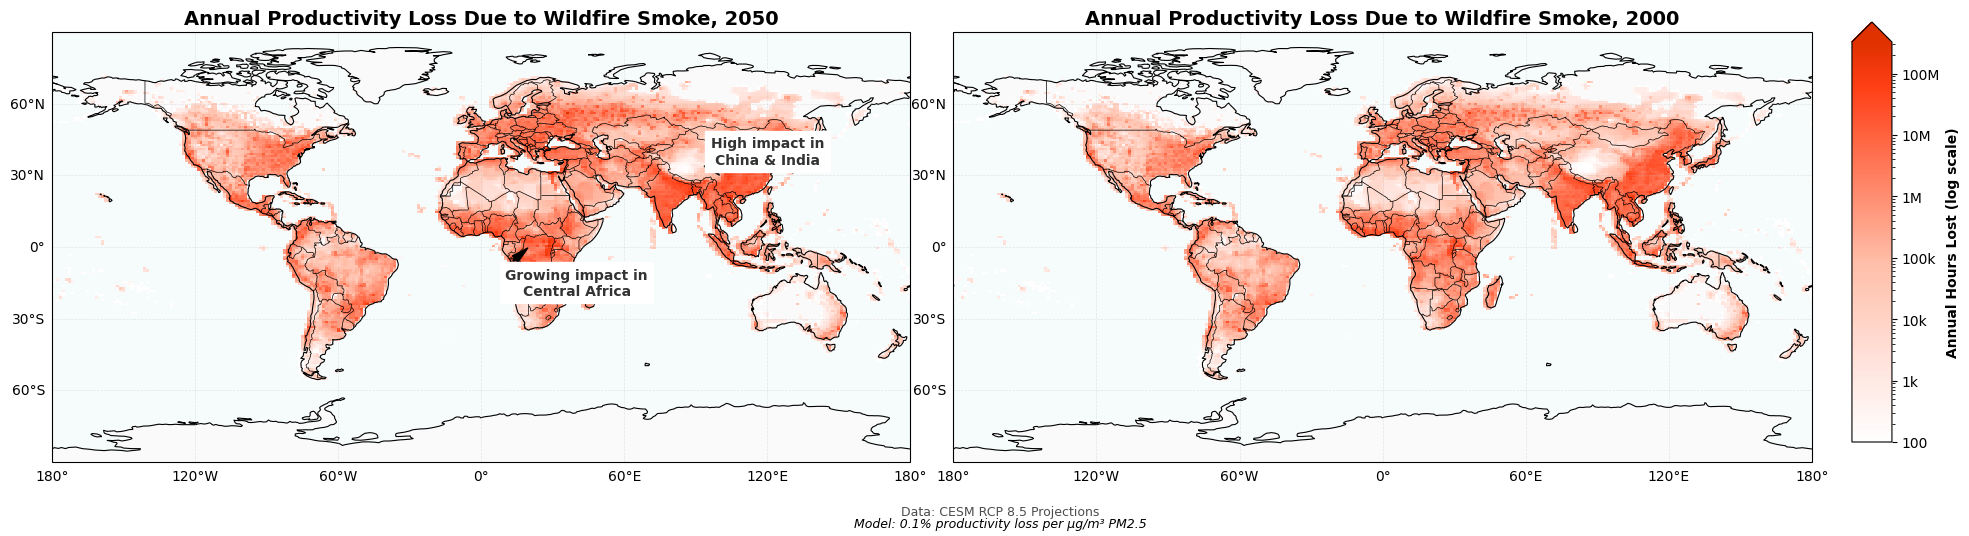

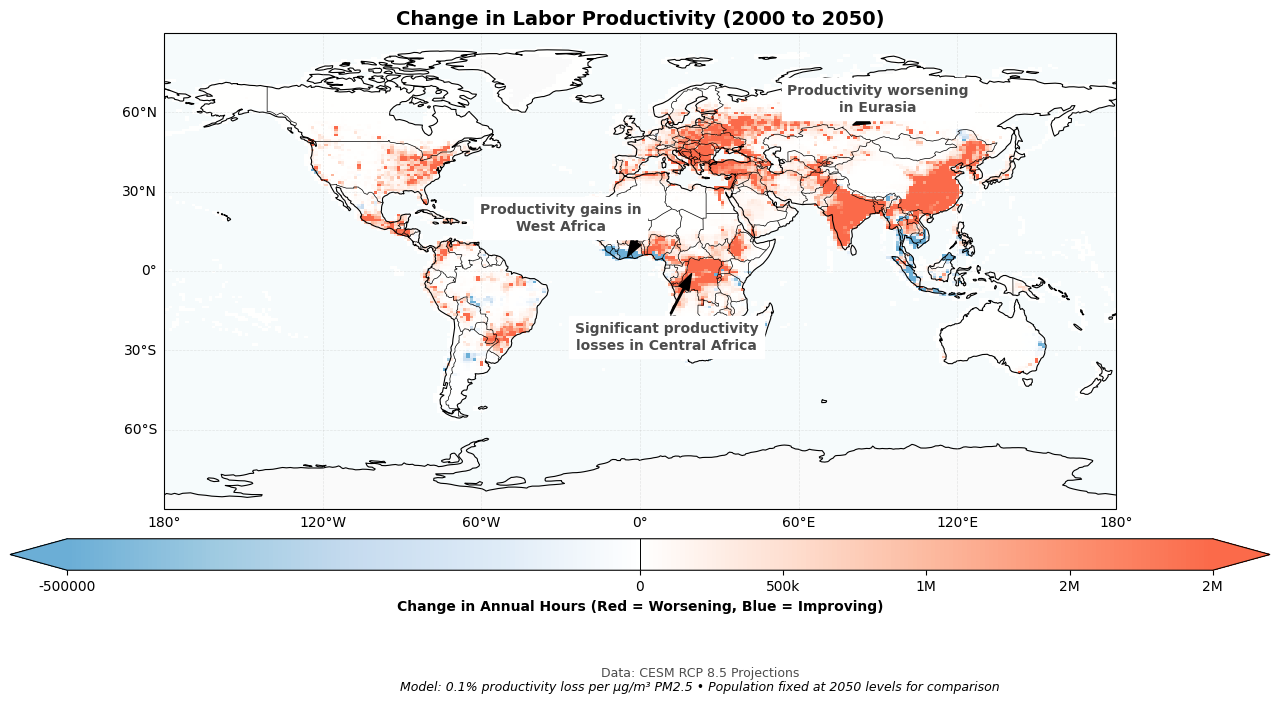

In [21]:
# Compare productivity losses in 2050 and 2000 side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Create a better colormap for productivity loss with smoother transitions using lighter colors
loss_colors = ['#ffffff', '#ffefeb', '#ffdfd7', '#ffcfbf', '#ffbfaa', '#ff9f85', '#ff7f60', '#ff5f3b', '#ff3f16', '#e03100']
loss_cmap = mcolors.LinearSegmentedColormap.from_list('productivity_loss', loss_colors)

# Set consistent color scale with log normalization for better visualization
vmax = max(wildfire_productivity_loss_2050.max(), wildfire_productivity_loss_2000.max())
norm = mcolors.LogNorm(vmin=100, vmax=vmax)

# 2050 productivity loss
p1 = wildfire_productivity_loss_2050.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap=loss_cmap,
    norm=norm,
    add_colorbar=False
)

# 2000 productivity loss
p2 = wildfire_productivity_loss_2000.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap=loss_cmap,
    norm=norm,
    add_colorbar=False
)

# Add features to both maps
for ax, year in zip(axes, ["2050", "2000"]):
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.1)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Add title
    ax.set_title(f"Annual Productivity Loss Due to Wildfire Smoke, {year}", fontsize=14, fontweight='bold')
    
    # Add annotations for high-impact regions
    if year == "2050":
        ax.annotate('High impact in\nChina & India', xy=(100, 30), xytext=(120, 40),
                   arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
                   fontweight='bold', ha='center', va='center', backgroundcolor='white', alpha=0.8)
        ax.annotate('Growing impact in\nCentral Africa', xy=(20, 0), xytext=(40, -15),
                   arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
                   fontweight='bold', ha='center', va='center', backgroundcolor='white', alpha=0.8)

# Add common colorbar with better tick formatting
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(p1, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label('Annual Hours Lost (log scale)', fontweight='bold')

# Custom tick formatter to show human-readable numbers
def format_func(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.0f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}k'
    else:
        return f'{x:.0f}'

formatter = FuncFormatter(format_func)
cbar.ax.yaxis.set_major_formatter(formatter)

# Add a note about the model and assumptions
plt.annotate('Model: 0.1% productivity loss per μg/m³ PM2.5', xy=(0.5, 0.01), xycoords='figure fraction', 
             fontsize=9, ha='center', va='bottom', style='italic')

# Add data attribution
plt.annotate(f'Data: CESM {rcp_display} Projections', xy=(0.5, 0.03), xycoords='figure fraction', 
             fontsize=9, ha='center', va='bottom', alpha=0.7)

# Use explicit subplot adjustment instead of tight_layout
plt.subplots_adjust(left=0.02, right=0.9, top=0.9, bottom=0.05, wspace=0.05)
plt.show()

# Visualize change in productivity loss between 2000 and 2050
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Create a lighter diverging colormap for change with white in the middle
# Lighter blue to white to lighter red
light_rdbu_colors = ['#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#ffffff', '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a']
light_rdbu = mcolors.LinearSegmentedColormap.from_list('light_rdbu', light_rdbu_colors)

# Use a diverging colormap for change with lighter colors and white center
divnorm = mcolors.TwoSlopeNorm(vmin=-5e5, vcenter=0, vmax=2e6)
p = change_wildfire_productivity_loss.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=light_rdbu,  # Using lighter red-blue colormap with white center
    norm=divnorm,
    add_colorbar=False
)

# Add features
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.1)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title
ax.set_title('Change in Labor Productivity (2000 to 2050)', fontsize=14, fontweight='bold')

# Add colorbar with better formatting
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, aspect=40, extend='both')
cbar.set_label('Change in Annual Hours (Red = Worsening, Blue = Improving)', fontweight='bold')

# Custom tick formatter
formatter = FuncFormatter(format_func)
cbar.ax.xaxis.set_major_formatter(formatter)

# Add zero line to colorbar
cbar.ax.axvline(x=0, color='black', linestyle='-', linewidth=0.7)

# Add annotations for regions with significant changes
ax.annotate('Productivity worsening\nin Eurasia', xy=(80, 55), xytext=(90, 65),
           arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
           fontweight='bold', ha='center', va='center', backgroundcolor='white', alpha=0.7)

ax.annotate('Significant productivity\nlosses in Central Africa', xy=(20, 0), xytext=(10, -25),
           arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
           fontweight='bold', ha='center', va='center', backgroundcolor='white', alpha=0.7)

ax.annotate('Productivity gains in\nWest Africa', xy=(-5, 5), xytext=(-30, 20),
           arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
           fontweight='bold', ha='center', va='center', backgroundcolor='white', alpha=0.7)

# Add a note about the model and assumptions
plt.annotate('Model: 0.1% productivity loss per μg/m³ PM2.5 • Population fixed at 2050 levels for comparison', 
             xy=(0.5, 0.01), xycoords='figure fraction', 
             fontsize=9, ha='center', va='bottom', style='italic')

# Add data attribution
plt.annotate(f'Data: CESM {rcp_display} Projections', xy=(0.5, 0.03), xycoords='figure fraction', 
             fontsize=9, ha='center', va='bottom', alpha=0.7)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
plt.show()

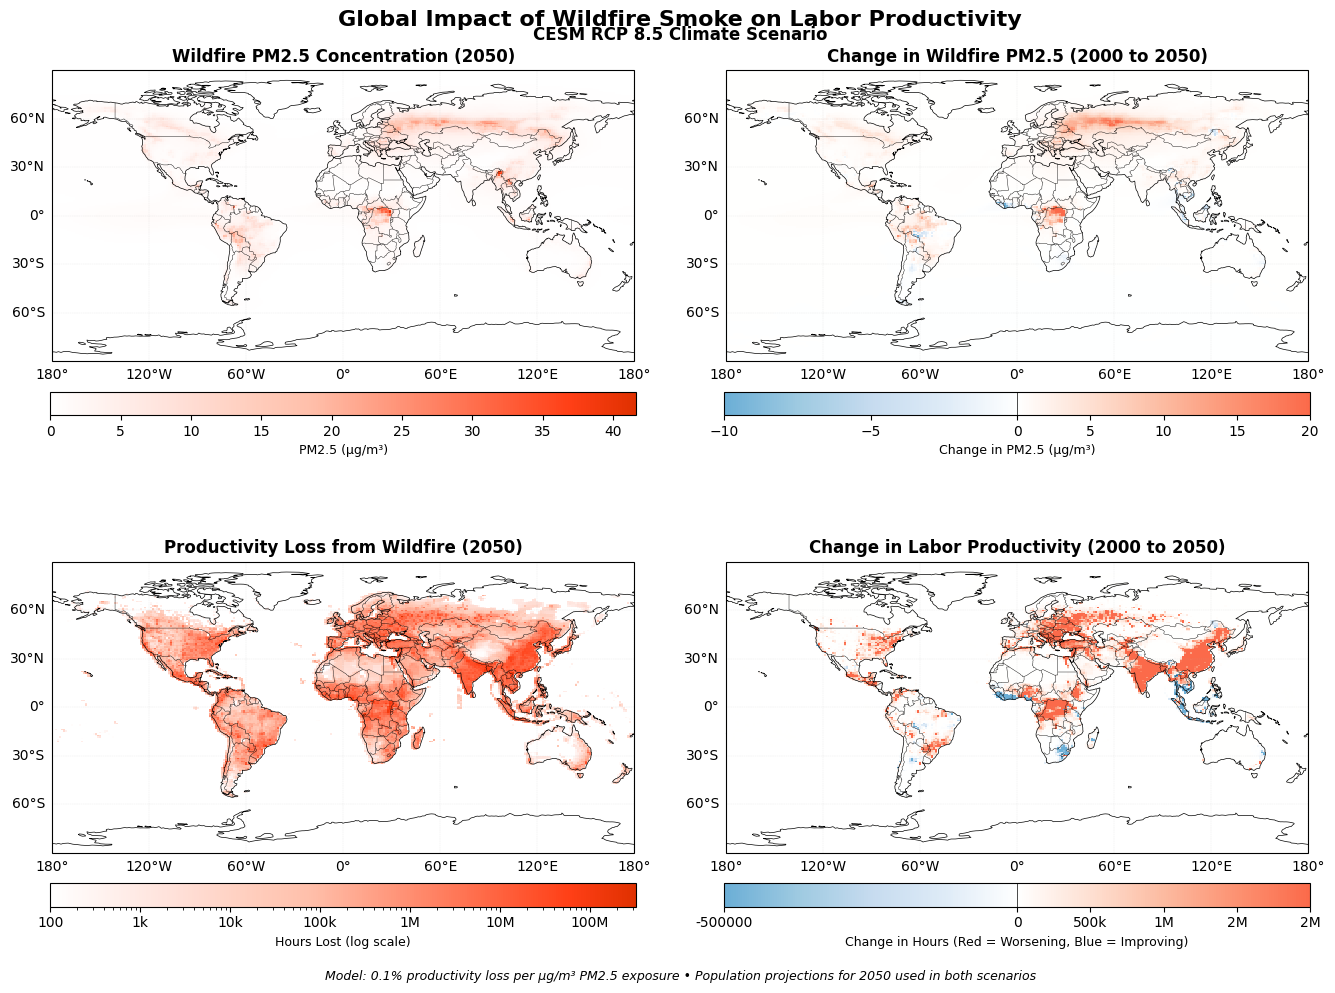

In [22]:
# Add a new cell for global spatial patterns of PM2.5 and productivity loss
fig = plt.figure(figsize=(14, 10))
fig.suptitle('Global Impact of Wildfire Smoke on Labor Productivity', fontsize=16, fontweight='bold', y=0.98)

# Use a more specific layout approach to avoid tight_layout issues with irregular axes
# Create a 2x2 grid of plots with specific positioning and sizing
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())

# Create white to red colormap for consistent use throughout the plots - using lighter colors
pm25_colors = ['#ffffff', '#ffefeb', '#ffdfd7', '#ffcfbf', '#ffbfaa', '#ff9f85', '#ff7f60', '#ff5f3b', '#ff3f16', '#e03100']
pm25_cmap = mcolors.LinearSegmentedColormap.from_list('pm25_concentration', pm25_colors)

# Create a lighter diverging colormap for change with white in the middle
# Lighter blue to white to lighter red
light_rdbu_colors = ['#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#ffffff', '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a']
light_rdbu = mcolors.LinearSegmentedColormap.from_list('light_rdbu', light_rdbu_colors)

# 1. PM2.5 from wildfire in 2050
p1 = fire_pm25_2050.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=pm25_cmap,  # Using consistent white to red colormap
    vmin=0,
    vmax=fire_pm25_2050.max().values * 0.8,  # Avoid outliers dominating the scale
    add_colorbar=False
)
ax1.set_title('Wildfire PM2.5 Concentration (2050)', fontweight='bold')
ax1.coastlines(linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.3)
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.3, alpha=0.3, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False
cbar1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', pad=0.08, aspect=25)
cbar1.set_label('PM2.5 (\u03bcg/m\u00b3)', fontsize=9)

# 2. Wildfire PM2.5 change from 2000 to 2050
p2 = pm25_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=light_rdbu,  # Using lighter red-blue colormap with white center
    norm=mcolors.TwoSlopeNorm(vmin=-10, vcenter=0, vmax=20),
    add_colorbar=False
)
ax2.set_title('Change in Wildfire PM2.5 (2000 to 2050)', fontweight='bold')
ax2.coastlines(linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.3)
gl2 = ax2.gridlines(draw_labels=True, linewidth=0.3, alpha=0.3, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False
cbar2 = plt.colorbar(p2, ax=ax2, orientation='horizontal', pad=0.08, aspect=25)
cbar2.set_label('Change in PM2.5 (\u03bcg/m\u00b3)', fontsize=9)
cbar2.ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# 3. Productivity loss from wildfire in 2050
p3 = wildfire_productivity_loss_2050.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=pm25_cmap,  # Using consistent white to red colormap
    norm=mcolors.LogNorm(vmin=100, vmax=wildfire_productivity_loss_2050.max().values),
    add_colorbar=False
)
ax3.set_title('Productivity Loss from Wildfire (2050)', fontweight='bold')
ax3.coastlines(linewidth=0.5)
ax3.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.3)
gl3 = ax3.gridlines(draw_labels=True, linewidth=0.3, alpha=0.3, linestyle='--')
gl3.top_labels = False
gl3.right_labels = False
cbar3 = plt.colorbar(p3, ax=ax3, orientation='horizontal', pad=0.08, aspect=25)
cbar3.set_label('Hours Lost (log scale)', fontsize=9)
cbar3.ax.xaxis.set_major_formatter(formatter)

# 4. Change in productivity loss from 2000 to 2050
p4 = change_wildfire_productivity_loss.plot(
    ax=ax4,
    transform=ccrs.PlateCarree(),
    cmap=light_rdbu,  # Using lighter red-blue colormap with white center
    norm=divnorm,
    add_colorbar=False
)
ax4.set_title('Change in Labor Productivity (2000 to 2050)', fontweight='bold')
ax4.coastlines(linewidth=0.5)
ax4.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=0.3)
gl4 = ax4.gridlines(draw_labels=True, linewidth=0.3, alpha=0.3, linestyle='--')
gl4.top_labels = False
gl4.right_labels = False
cbar4 = plt.colorbar(p4, ax=ax4, orientation='horizontal', pad=0.08, aspect=25)
cbar4.set_label('Change in Hours (Red = Worsening, Blue = Improving)', fontsize=9)
cbar4.ax.xaxis.set_major_formatter(formatter)
cbar4.ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add a data attribution label at the top
plt.figtext(0.5, 0.95, f"CESM {rcp_display} Climate Scenario", ha='center', fontsize=12, fontweight='bold')

# Add explanation of model at bottom of figure
plt.figtext(0.5, 0.01, 
           'Model: 0.1% productivity loss per \u03bcg/m\u00b3 PM2.5 exposure \u2022 Population projections for 2050 used in both scenarios', 
           ha='center', fontsize=9, style='italic')

# Use a better layout approach instead of tight_layout
plt.subplots_adjust(top=0.92, bottom=0.05, left=0.05, right=0.95, hspace=0.3, wspace=0.15)
plt.show()

## Country-Level Analysis

Examine the countries most affected by wildfire smoke productivity losses.

In [23]:
# Top 10 countries with highest productivity losses due to wildfire in 2050
top_countries_2050 = wildfire_country_losses_2050.sort_values(ascending=False).head(10)
print("Top 10 countries with highest productivity losses due to wildfire in 2050 (hours):")
display(top_countries_2050)

# Convert to work-years for better interpretation
top_countries_years_2050 = top_countries_2050 * work_years_factor
print("\nTop 10 countries with highest productivity losses due to wildfire in 2050 (work-years):")
display(top_countries_years_2050)

Top 10 countries with highest productivity losses due to wildfire in 2050 (hours):


China                       5.578521e+09
India                       3.312524e+09
Dem. Rep. Congo             2.451458e+09
Russia                      1.870211e+09
United States of America    1.077755e+09
Brazil                      8.141409e+08
Nigeria                     6.159188e+08
Bangladesh                  4.637822e+08
Vietnam                     4.241807e+08
Myanmar                     4.181993e+08
Name: Productivity Loss (Hours), dtype: float64


Top 10 countries with highest productivity losses due to wildfire in 2050 (work-years):


China                       2.789261e+06
India                       1.656262e+06
Dem. Rep. Congo             1.225729e+06
Russia                      9.351056e+05
United States of America    5.388775e+05
Brazil                      4.070705e+05
Nigeria                     3.079594e+05
Bangladesh                  2.318911e+05
Vietnam                     2.120903e+05
Myanmar                     2.090996e+05
Name: Productivity Loss (Hours), dtype: float64

In [24]:
# Top 10 countries with highest productivity losses due to wildfire in 2000
top_countries_2000 = wildfire_country_losses_2000.sort_values(ascending=False).head(10)
print("Top 10 countries with highest productivity losses due to wildfire in 2000 (hours):")
display(top_countries_2000)

# Convert to work-years for better interpretation
top_countries_years_2000 = top_countries_2000 * work_years_factor
print("\nTop 10 countries with highest productivity losses due to wildfire in 2000 (work-years):")
display(top_countries_years_2000)

Top 10 countries with highest productivity losses due to wildfire in 2000 (hours):


China                       3.837204e+09
India                       1.996204e+09
Dem. Rep. Congo             8.476425e+08
United States of America    6.753180e+08
Russia                      6.731947e+08
Nigeria                     6.371689e+08
Brazil                      5.293450e+08
Myanmar                     4.139750e+08
Indonesia                   3.890698e+08
Vietnam                     3.827430e+08
Name: Productivity Loss (Hours), dtype: float64


Top 10 countries with highest productivity losses due to wildfire in 2000 (work-years):


China                       1.918602e+06
India                       9.981021e+05
Dem. Rep. Congo             4.238212e+05
United States of America    3.376590e+05
Russia                      3.365973e+05
Nigeria                     3.185844e+05
Brazil                      2.646725e+05
Myanmar                     2.069875e+05
Indonesia                   1.945349e+05
Vietnam                     1.913715e+05
Name: Productivity Loss (Hours), dtype: float64

In [25]:
# Top 10 countries with largest change in productivity losses from 2000 to 2050
top_increase = wildfire_country_change.sort_values(ascending=False).head(10)
print("Top 10 countries with largest INCREASE in productivity losses from 2000 to 2050 (hours):")
display(top_increase)

# Top 10 countries with largest decrease in productivity losses from 2000 to 2050
top_decrease = wildfire_country_change.sort_values(ascending=True).head(10)
print("\nTop 10 countries with largest DECREASE in productivity losses from 2000 to 2050 (hours):")
display(top_decrease)

Top 10 countries with largest INCREASE in productivity losses from 2000 to 2050 (hours):


China                       1.741317e+09
Dem. Rep. Congo             1.603816e+09
India                       1.316320e+09
Russia                      1.197016e+09
United States of America    4.024371e+08
Brazil                      2.847959e+08
Ukraine                     2.266043e+08
Turkey                      1.999488e+08
Bangladesh                  1.564033e+08
Egypt                       1.379242e+08
Name: Productivity Loss (Hours), dtype: float64


Top 10 countries with largest DECREASE in productivity losses from 2000 to 2050 (hours):


Côte d'Ivoire   -1.865098e+08
Cambodia        -9.208613e+07
Sierra Leone    -4.978721e+07
South Africa    -4.354787e+07
Ghana           -4.072572e+07
Indonesia       -3.005309e+07
Liberia         -2.712106e+07
Nigeria         -2.125009e+07
Philippines     -1.712093e+07
Malaysia        -1.001303e+07
Name: Productivity Loss (Hours), dtype: float64

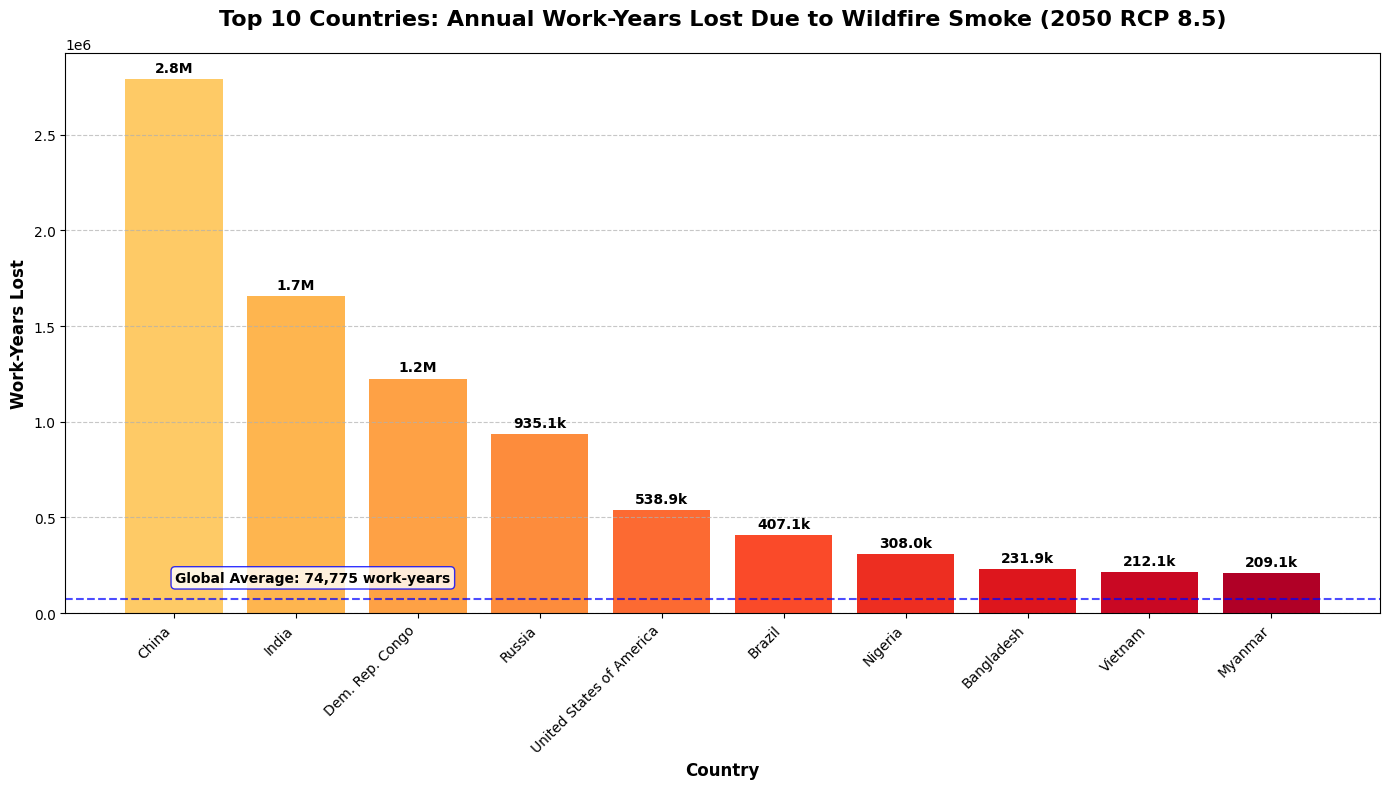

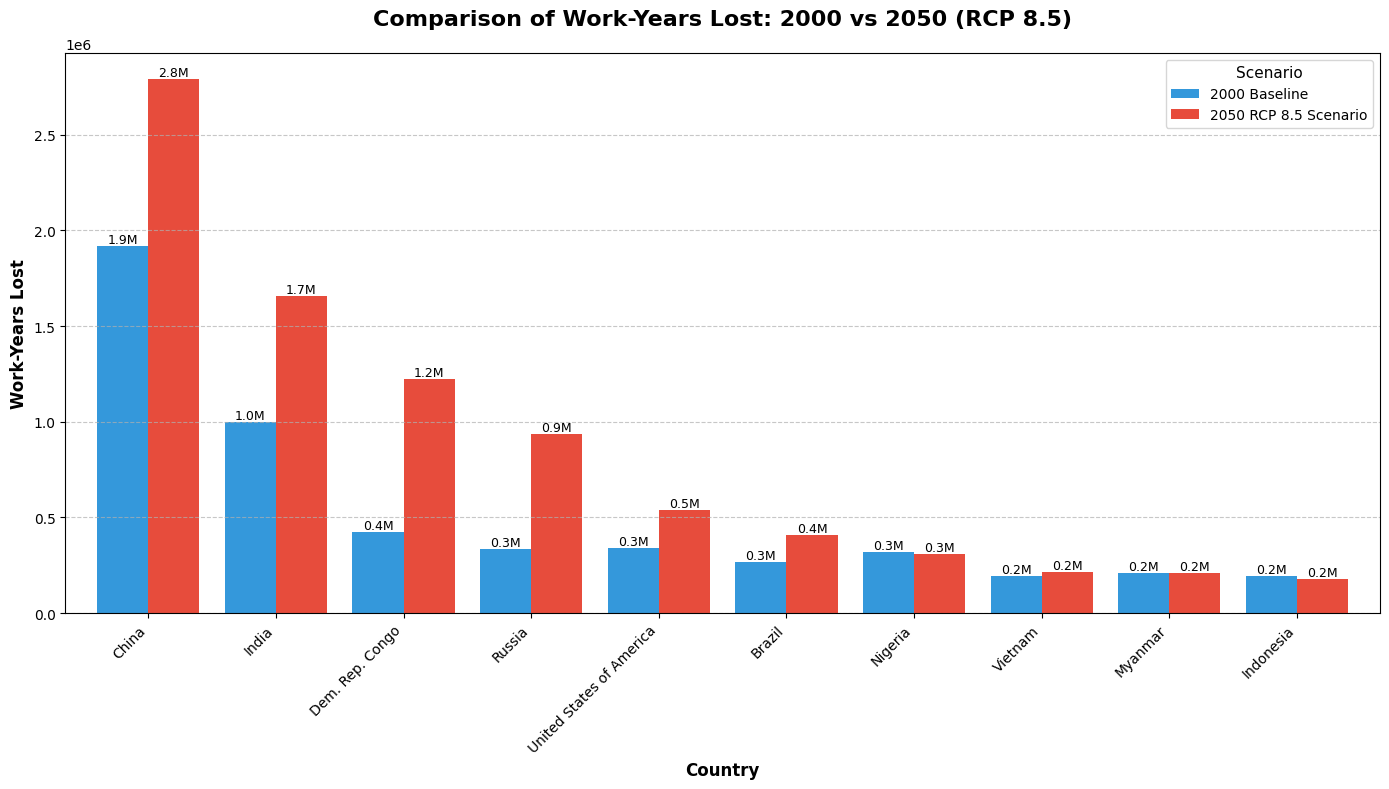

In [26]:
# Improved visualization of top countries' productivity losses with better formatting
fig, ax = plt.subplots(figsize=(14, 8))

# Use a more readable colormap with sequential gradient
country_colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(top_countries_years_2050)))

# Create bar chart with formatted values
bars = ax.bar(top_countries_years_2050.index, top_countries_years_2050.values, color=country_colors)

# Add formatted value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    formatted_value = f'{height/1e6:.1f}M' if height >= 1e6 else f'{height/1e3:.1f}k'
    ax.annotate(formatted_value,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontweight='bold')

# Add title and labels with better formatting
ax.set_title(f'Top 10 Countries: Annual Work-Years Lost Due to Wildfire Smoke (2050 {rcp_display})', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Work-Years Lost', fontsize=12, fontweight='bold')
ax.set_xlabel('Country', fontsize=12, fontweight='bold')

# Improve readability of country names
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line for the global average
global_avg = wildfire_country_losses_2050.mean() * work_years_factor
ax.axhline(y=global_avg, color='blue', linestyle='--', alpha=0.7)
ax.annotate(f'Global Average: {global_avg:,.0f} work-years', 
            xy=(0, global_avg), xytext=(1, 10),
            textcoords="offset points", ha='left', va='bottom',
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8))

plt.tight_layout()
plt.show()

# Create a side-by-side comparison of 2000 and 2050 productivity losses for top countries
fig, ax = plt.subplots(figsize=(14, 8))

# Get top countries across both 2000 and 2050 (union of both sets)
top_countries_combined = pd.concat([top_countries_2000, top_countries_2050]).index.unique()[:10]
comparison_data = pd.DataFrame({
    '2000': [wildfire_country_losses_2000.get(country, 0) * work_years_factor for country in top_countries_combined],
    '2050': [wildfire_country_losses_2050.get(country, 0) * work_years_factor for country in top_countries_combined]
}, index=top_countries_combined)

# Sort by 2050 values
comparison_data = comparison_data.sort_values('2050', ascending=False)

# Plot side-by-side bars
comparison_data.plot(kind='bar', ax=ax, width=0.8, color=['#3498db', '#e74c3c'])

# Add title and labels
ax.set_title(f'Comparison of Work-Years Lost: 2000 vs 2050 ({rcp_display})', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Work-Years Lost', fontsize=12, fontweight='bold')
ax.set_xlabel('Country', fontsize=12, fontweight='bold')

# Improve axis formatting
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, (_, row) in enumerate(comparison_data.iterrows()):
    # 2000 value
    if row['2000'] > 100000:  # Only label significant values
        ax.annotate(f"{row['2000']/1e6:.1f}M",
                    xy=(i-0.2, row['2000']),
                    ha='center', va='bottom',
                    fontsize=9)
    
    # 2050 value
    if row['2050'] > 100000:  # Only label significant values
        ax.annotate(f"{row['2050']/1e6:.1f}M",
                    xy=(i+0.2, row['2050']),
                    ha='center', va='bottom',
                    fontsize=9)

# Add a legend with better formatting
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['2000 Baseline', f'2050 {rcp_display} Scenario'], 
          loc='upper right', fontsize=10, frameon=True, 
          title='Scenario', title_fontsize=11)

plt.tight_layout()
plt.show()

## Per Capita Analysis

Examine the per capita productivity losses to see which populations are most affected.

In [27]:
# Get top 10 countries by per capita impact in 2050
top_per_capita_2050 = per_capita_loss_2050.sort_values(ascending=False).head(10)
print("Top 10 countries with highest per capita productivity losses due to wildfire in 2050 (hours/person):")
display(top_per_capita_2050)

Top 10 countries with highest per capita productivity losses due to wildfire in 2050 (hours/person):


Belarus                 16.562195
Central African Rep.    15.708756
Laos                    15.638093
Russia                  14.208453
Dem. Rep. Congo         12.826674
Romania                 11.943601
Ukraine                 11.065530
Latvia                  10.477527
Estonia                 10.137931
Congo                    9.892481
Name: Per Capita Productivity Loss 2050 (Hours), dtype: float64

In [28]:
# Get top 10 countries by per capita impact in 2000
top_per_capita_2000 = per_capita_loss_2000.sort_values(ascending=False).head(10)
print("Top 10 countries with highest per capita productivity losses due to wildfire in 2000 (hours/person):")
display(top_per_capita_2000)

Top 10 countries with highest per capita productivity losses due to wildfire in 2000 (hours/person):


Sierra Leone     14.323615
Laos             13.305819
Côte d'Ivoire     9.709200
Liberia           8.536091
Myanmar           7.150974
Vietnam           7.140969
Bolivia           7.063186
Cambodia          6.349866
Belarus           6.278227
Congo             6.090181
Name: Per Capita Productivity Loss 2000 (Hours), dtype: float64

In [29]:
# Get top 10 countries by change in per capita impact from 2000 to 2050
top_per_capita_increase = per_capita_change.sort_values(ascending=False).head(10)
print("Top 10 countries with largest INCREASE in per capita productivity losses from 2000 to 2050 (hours/person):")
display(top_per_capita_increase)

# Get bottom 10 countries by change in per capita impact from 2000 to 2050
top_per_capita_decrease = per_capita_change.sort_values(ascending=True).head(10)
print("\nTop 10 countries with largest DECREASE in per capita productivity losses from 2000 to 2050 (hours/person):")
display(top_per_capita_decrease)

Top 10 countries with largest INCREASE in per capita productivity losses from 2000 to 2050 (hours/person):


Belarus                 10.283969
Central African Rep.    10.054974
Russia                   9.094027
Dem. Rep. Congo          8.391586
Romania                  7.130070
Ukraine                  6.533512
Latvia                   6.401010
Estonia                  5.985307
Croatia                  5.882447
Serbia                   5.198526
Name: Per Capita Productivity Loss Change 2000-2050 (Hours), dtype: float64


Top 10 countries with largest DECREASE in per capita productivity losses from 2000 to 2050 (hours/person):


Sierra Leone    -6.481087
Côte d'Ivoire   -5.386754
Liberia         -3.007843
Cambodia        -2.294924
Malaysia        -1.374535
Ghana           -0.783037
South Africa    -0.752782
Philippines     -0.496217
eSwatini        -0.360995
Botswana        -0.352316
Name: Per Capita Productivity Loss Change 2000-2050 (Hours), dtype: float64

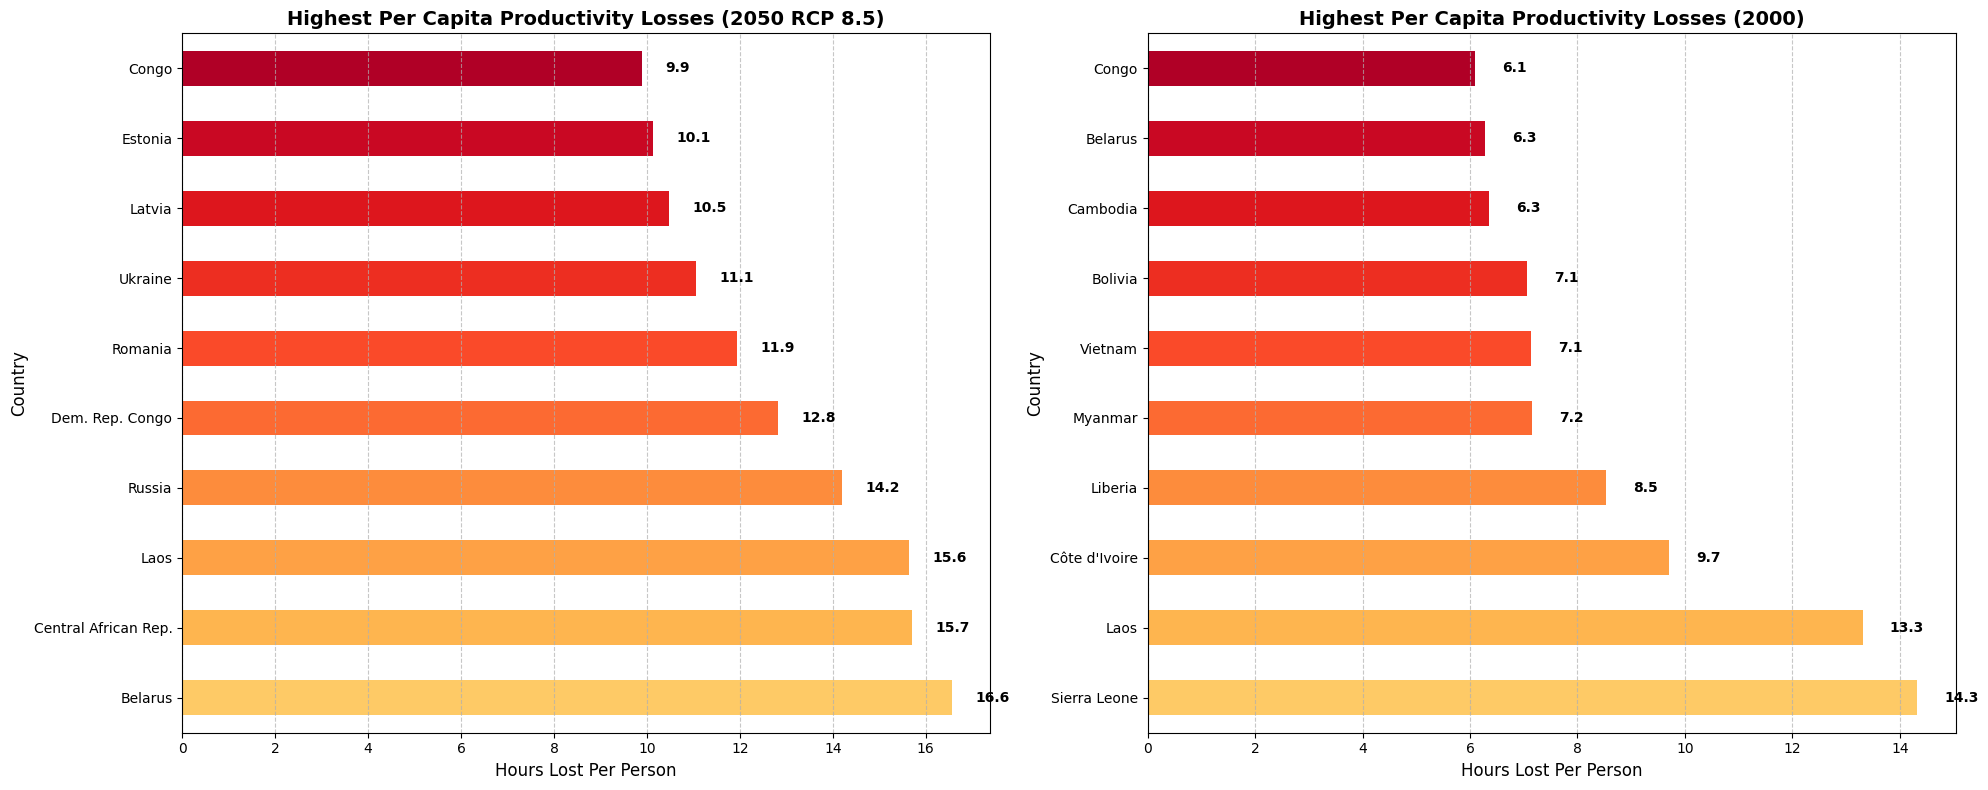

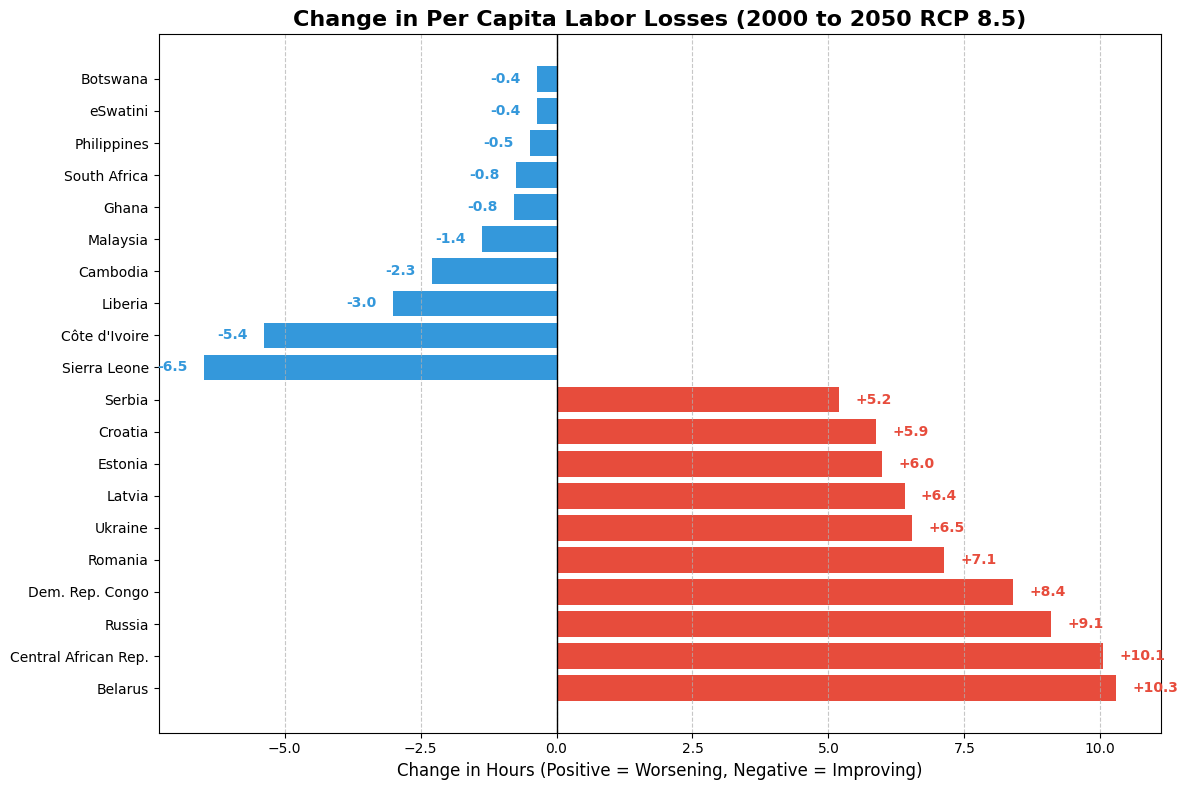

In [30]:
# Improved visualization of per capita productivity losses with better formatting and side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Use a consistent color scheme with the white to red colors
per_capita_colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, 10))  # Using YlOrRd instead of Blues

# Plot 2050 per capita impacts
top_per_capita_2050.plot(kind='barh', ax=axes[0], color=per_capita_colors)
axes[0].set_title(f'Highest Per Capita Productivity Losses (2050 {rcp_display})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hours Lost Per Person', fontsize=12)
axes[0].set_ylabel('Country', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(top_per_capita_2050):
    axes[0].text(v + 0.5, i, f'{v:.1f}', va='center', fontweight='bold')

# Plot 2000 per capita impacts
top_per_capita_2000.plot(kind='barh', ax=axes[1], color=per_capita_colors)
axes[1].set_title('Highest Per Capita Productivity Losses (2000)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hours Lost Per Person', fontsize=12)
axes[1].set_ylabel('Country', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(top_per_capita_2000):
    axes[1].text(v + 0.5, i, f'{v:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Create a figure showing per capita changes
fig, ax = plt.subplots(figsize=(12, 8))

# Create datasets for increase and decrease
increase_data = top_per_capita_increase.sort_values(ascending=False)
decrease_data = top_per_capita_decrease.sort_values(ascending=True)

# Create arrays for plotting
countries = list(increase_data.index) + list(decrease_data.index)
values = list(increase_data.values) + list(decrease_data.values)
y_pos = np.arange(len(countries))

# Color increases red and decreases blue
colors = ['#e74c3c' if v > 0 else '#3498db' for v in values]

# Create bars
bars = ax.barh(y_pos, values, color=colors)

# Set y-tick labels to country names
ax.set_yticks(y_pos)
ax.set_yticklabels(countries)

# Add a vertical line at x=0
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Add title and labels
ax.set_title(f'Change in Per Capita Labor Losses (2000 to 2050 {rcp_display})', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Change in Hours (Positive = Worsening, Negative = Improving)', fontsize=12)

# Add value labels
for i, v in enumerate(values):
    if v > 0:
        ax.text(v + 0.3, i, f'+{v:.1f}', va='center', ha='left', fontweight='bold', color='#e74c3c')
    else:
        ax.text(v - 0.3, i, f'{v:.1f}', va='center', ha='right', fontweight='bold', color='#3498db')

# Add grid
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add annotations explaining the significance
ax.annotate('Productivity worsening\nin Eastern Europe & Russia', 
            xy=(15, 2), xytext=(13, 2),
            ha='right', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#e74c3c", alpha=0.8))

ax.annotate('Productivity improving\nin West Africa', 
            xy=(-10, len(increase_data) + 2), xytext=(-8, len(increase_data) + 2),
            ha='left', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#3498db", alpha=0.8))

plt.tight_layout()
plt.show()